In [1]:
pip install torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
# Define transformations - basic preprocessing only since using pre-augmented dataset
train_transforms = transforms.Compose([
    transforms.Resize((299, 299)),  # Inception v3 requires 299x299 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Standard ImageNet normalization
                         std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((299, 299)),  # Inception v3 requires 299x299 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [4]:
# Paths
train_dir = "Dataset_Augmented/Train"
test_dir = "Dataset/Test"

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

# Create loaders
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Class mapping and dataset info
class_names = train_dataset.classes
print("Classes:", class_names)
print(f"\nDataset Information:")
print(f"Training images: {len(train_dataset)}")
print(f"Test images: {len(test_dataset)}")
print(f"Total images: {len(train_dataset) + len(test_dataset)}")

# Show class distribution
for i, class_name in enumerate(class_names):
    train_count = len([x for x in train_dataset.samples if x[1] == i])
    test_count = len([x for x in test_dataset.samples if x[1] == i])
    print(f"{class_name}: {train_count} train, {test_count} test")

Classes: ['Kidney_stone', 'Normal']

Dataset Information:
Training images: 11624
Test images: 346
Total images: 11970
Kidney_stone: 5000 train, 165 test
Normal: 6624 train, 181 test


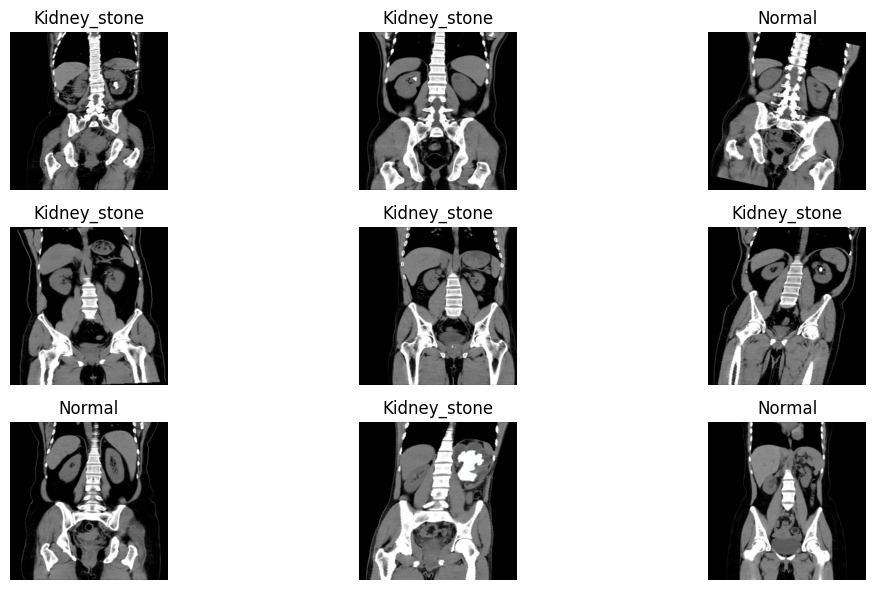

In [5]:
def imshow(img, title):
    img = img.numpy().transpose((1, 2, 0))
    mean = [0.485, 0.456, 0.406]
    std  = [0.229, 0.224, 0.225]
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# Show a few training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

plt.figure(figsize=(12,6))
for i in range(9):
    plt.subplot(3, 3, i+1)
    imshow(images[i], title=class_names[labels[i]])
plt.tight_layout()
plt.show()


In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained Inception v3
backbone = models.inception_v3(weights=torchvision.models.Inception_V3_Weights.DEFAULT, aux_logits=True)

# Freeze all layers for feature extraction
for param in backbone.parameters():
    param.requires_grad = False

# Remove the original classification layers
backbone.fc = nn.Identity()  # Remove final layer
backbone.AuxLogits.fc = nn.Identity()  # Remove aux classifier

# Create custom classification head following the research paper
class CustomClassifier(nn.Module):
    def __init__(self, input_features=2048):
        super(CustomClassifier, self).__init__()
        self.classifier = nn.Sequential(
            # First dense layer with 256 neurons
            nn.Linear(input_features, 256),
            nn.BatchNorm1d(256),  # Batch normalization
            nn.ReLU(),
            nn.Dropout(0.2),  # 20% dropout

            # Second dense layer with 128 neurons
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),  # Batch normalization again
            nn.ReLU(),

            # Final classification layer
            nn.Linear(128, 2)  # Binary classification
        )

    def forward(self, x):
        return self.classifier(x)

# Create the complete model
class FeatureExtractionModel(nn.Module):
    def __init__(self, backbone, classifier):
        super(FeatureExtractionModel, self).__init__()
        self.backbone = backbone
        self.classifier = classifier

    def forward(self, x):
        # Extract features using frozen backbone
        features = self.backbone(x)

        # Handle Inception v3's auxiliary output during training
        if isinstance(features, tuple):  # Training mode returns (main, aux)
            features = features[0]  # Use main output

        # Flatten features if needed
        if len(features.shape) > 2:
            features = features.view(features.size(0), -1)

        # Classify using custom head
        output = self.classifier(features)
        return output

# Initialize the model
custom_classifier = CustomClassifier(input_features=2048)
model = FeatureExtractionModel(backbone, custom_classifier)
model = model.to(device)

model_path = 'models/inception_v3_kidney_stone_model.pth'
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    print("✅ Model weights loaded successfully.")
else:
    print("❌ No saved model found. Starting from scratch.")

print("Model Architecture:")
print("- Frozen Inception v3 backbone for feature extraction")
print("- Custom classifier: 2048 → 256 → BN → Dropout → 128 → BN → 2")
print(f"- Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"- Total parameters: {sum(p.numel() for p in model.parameters()):,}")

✅ Model weights loaded successfully.
Model Architecture:
- Frozen Inception v3 backbone for feature extraction
- Custom classifier: 2048 → 256 → BN → Dropout → 128 → BN → 2
- Total trainable parameters: 558,466
- Total parameters: 24,901,730


In [20]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.0005)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)  # optional

In [17]:
def train_model(EPOCHS, step_lr=False):
  for epoch in range(EPOCHS):
      model.train()
      running_loss = 0.0
      correct, total = 0, 0

      for inputs, labels in train_loader:
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()
          outputs = model(inputs)  # Single output from custom classifier
          loss = criterion(outputs, labels)

          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      if step_lr == True:
        scheduler.step()
      print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%", flush=True)

In [21]:
for param in backbone.parameters():
    param.requires_grad = True

print("Model Architecture:")
print("- Frozen Inception v3 backbone for feature extraction")
print("- Custom classifier: 2048 → 256 → BN → Dropout → 128 → BN → 2")
print(f"- Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"- Total parameters: {sum(p.numel() for p in model.parameters()):,}")

train_model(2)

Model Architecture:
- Frozen Inception v3 backbone for feature extraction
- Custom classifier: 2048 → 256 → BN → Dropout → 128 → BN → 2
- Total trainable parameters: 24,901,730
- Total parameters: 24,901,730
Epoch 1/2 - Loss: 0.0120, Accuracy: 99.75%
Epoch 2/2 - Loss: 0.0099, Accuracy: 99.71%


In [69]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}% ({correct}/{total} images correctly classified)")

Test Accuracy: 99.42% (344/346 images correctly classified)


In [23]:
# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the complete model
torch.save(model.state_dict(), 'models/inception_v3_kidney_stone_model.pth')

# Also save the model architecture info for later loading
model_info = {
    'input_features': 2048,
    'num_classes': 2,
    'architecture': 'Inception_v3_CustomClassifier'
}

torch.save(model_info, 'models/model_info.pth')

print("✅ Model saved successfully!")
print("📁 Model weights: models/inception_v3_kidney_stone_model.pth")
print("📁 Model info: models/model_info.pth")

✅ Model saved successfully!
📁 Model weights: models/inception_v3_kidney_stone_model.pth
📁 Model info: models/model_info.pth


In [24]:
try:
    from google.colab import files

    print("📥 Downloading model files...")

    # Download the model weights
    files.download('models/inception_v3_kidney_stone_model.pth')

    # Download the model info
    files.download('models/model_info.pth')

    print("✅ Files downloaded successfully!")
    print("💾 Check your Downloads folder for:")
    print("   - inception_v3_kidney_stone_model.pth")
    print("   - model_info.pth")

except ImportError:
    print("⚠️  Not running in Google Colab - skipping download")
except Exception as e:
    print(f"❌ Download failed: {e}")
    print("💡 Alternative: Use the file browser on the left to download manually")

📥 Downloading model files...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Files downloaded successfully!
💾 Check your Downloads folder for:
   - inception_v3_kidney_stone_model.pth
   - model_info.pth
